In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, f_oneway # pearsonr cho tương quan Pearson, f_oneway cho ANOVA
import statsmodels.api as sm
from statsmodels.formula.api import ols

# --- 1. Tải dữ liệu ---
try:
    df = pd.read_csv("/content/analyzed_data.csv", encoding="windows-1252") # Thay 'your_sales_data.csv' bằng tên file của bạn
    print("Dữ liệu đã được tải thành công.")
    print(f"Kích thước dữ liệu: {df.shape}")
    print("5 hàng đầu tiên của dữ liệu:")
    print(df.head())
except FileNotFoundError:
    print("Lỗi: Không tìm thấy file 'your_sales_data.csv'. Vui lòng kiểm tra lại tên file và đường dẫn.")
    exit()

# --- 2. Tiền xử lý dữ liệu cơ bản và Tạo biến 'Revenue' nếu chưa có ---
# Nếu 'Revenue' của bạn đã tồn tại, hãy bỏ qua phần này.
# Nếu 'Revenue' chưa có và bạn muốn tính từ 'Sales', giả sử Revenue = Sales
if 'Revenue' not in df.columns:
    if 'Sales' in df.columns:
        df['Revenue'] = df['Sales']
        print("\nBiến 'Revenue' được tạo từ 'Sales'.")
    else:
        print("\nCảnh báo: Không tìm thấy cột 'Revenue' hoặc 'Sales'. Vui lòng kiểm tra lại dữ liệu của bạn. Không thể tiếp tục phân tích tương quan.")
        exit()

# Chuyển đổi cột ngày tháng sang định dạng datetime để trích xuất Month và Year
df['Order Date'] = pd.to_datetime(df['Order Date'])
df['Ship Date'] = pd.to_datetime(df['Ship Date'])

# Trích xuất Month và Year nếu chưa có
if 'Month' not in df.columns:
    df['Month'] = df['Order Date'].dt.month
if 'Year' not in df.columns:
    df['Year'] = df['Order Date'].dt.year

# Xử lý giá trị thiếu (nếu có) trước khi phân tích
# Điền giá trị thiếu cho cột số bằng trung bình
for col in df.select_dtypes(include=['int64', 'float64']).columns:
    if df[col].isnull().any():
        df[col] = df[col].fillna(df[col].mean())

# Điền giá trị thiếu cho cột định tính bằng mode
for col in df.select_dtypes(include='object').columns:
    if df[col].isnull().any():
        df[col] = df[col].fillna(df[col].mode()[0])


Dữ liệu đã được tải thành công.
Kích thước dữ liệu: (7888, 24)
5 hàng đầu tiên của dữ liệu:
   Row ID        Order ID  Order Date   Ship Date       Ship Mode Customer ID  \
0       1  CA-2016-152156  2016-11-08  11/11/2016    Second Class    CG-12520   
1       3  CA-2016-138688  2016-06-12   6/16/2016    Second Class    DV-13045   
2       5  US-2015-108966  2015-10-11  10/18/2015  Standard Class    SO-20335   
3       6  CA-2014-115812  2014-06-09   6/14/2014  Standard Class    BH-11710   
4       7  CA-2014-115812  2014-06-09   6/14/2014  Standard Class    BH-11710   

     Customer Name    Segment        Country             City  ...  \
0      Claire Gute   Consumer  United States        Henderson  ...   
1  Darrin Van Huff  Corporate  United States      Los Angeles  ...   
2   Sean O'Donnell   Consumer  United States  Fort Lauderdale  ...   
3  Brosina Hoffman   Consumer  United States      Los Angeles  ...   
4  Brosina Hoffman   Consumer  United States      Los Angeles  ...   



In [7]:

# --- 3. Phân tích tương quan Pearson cho biến số ---
print("\n--- Phân tích tương quan Pearson (cho biến số) ---")

numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
if 'Row ID' in numerical_features: # Loại bỏ các ID không phải là biến số thực sự
    numerical_features.remove('Row ID')
if 'Postal Code' in numerical_features: # Postal Code thường được coi là định tính
    numerical_features.remove('Postal Code')
target = None
if 'Revenue' in numerical_features:
    target = 'Revenue'
    numerical_features.remove('Revenue')



print(f"Các biến số được phân tích tương quan: {numerical_features}")

correlation_results = {}
for feature in numerical_features:
    if feature != target: # Không tính tương quan của biến với chính nó
        corr, _ = pearsonr(df[feature], df['Revenue'])
        correlation_results[feature] = corr

correlation_df = pd.DataFrame(correlation_results.items(), columns=['Feature', 'Pearson Correlation'])
correlation_df['Absolute Correlation'] = correlation_df['Pearson Correlation'].abs()
correlation_df = correlation_df.sort_values(by='Absolute Correlation', ascending=False)

print("\nKết quả tương quan Pearson với Revenue:")
print(correlation_df)



--- Phân tích tương quan Pearson (cho biến số) ---
Các biến số được phân tích tương quan: ['Sales', 'Quantity', 'Discount', 'Profit', 'Month', 'Year']

Kết quả tương quan Pearson với Revenue:
    Feature  Pearson Correlation  Absolute Correlation
0     Sales             0.832679              0.832679
1  Quantity             0.492286              0.492286
3    Profit             0.425565              0.425565
2  Discount             0.028261              0.028261
4     Month            -0.015143              0.015143
5      Year             0.002217              0.002217


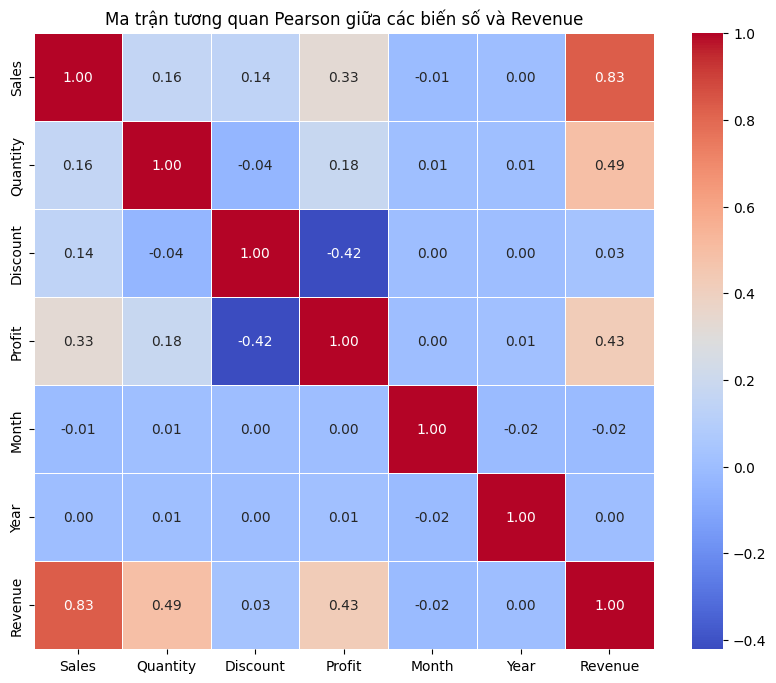

In [8]:

# --- 4. Trực quan hóa tương quan Pearson ---
plt.figure(figsize=(10, 8))
sns.heatmap(df[numerical_features + ['Revenue']].corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Ma trận tương quan Pearson giữa các biến số và Revenue')
plt.show()


In [12]:

# --- 5. Phân tích ANOVA cho biến định tính ---
print("\n--- Phân tích ANOVA (cho biến định tính) ---")

# Các biến định tính tiềm năng (loại bỏ các ID)
categorical_features = [
    'Ship Mode', 'Segment', 'Country', 'City', 'State', 'Region',
    'Category', 'Sub-Category',
    'Month', 'Year' # Month và Year cũng có thể được coi là định tính trong một số trường hợp
]
# Lọc các biến định tính có trong DataFrame của bạn
categorical_features = [col for col in categorical_features if col in df.columns]

# Loại bỏ các cột có quá nhiều giá trị duy nhất (ví dụ: Customer Name, Product Name)
# để tránh ANOVA quá tải hoặc không có ý nghĩa
high_cardinality_cols = ['Customer ID', 'Customer Name', 'Product ID', 'Product Name', 'Order ID']
categorical_features = [col for col in categorical_features if col not in high_cardinality_cols]


print(f"Các biến định tính được phân tích ANOVA: {categorical_features}")
print(len(df["City"].unique()))
print(len(df["Country"].unique()))
anova_results = {}
for feature in categorical_features:
    # Lấy các nhóm duy nhất của biến định tính
    unique_groups = df[feature].unique()
    if len(unique_groups) > 1 and len(unique_groups) <= 515: # Giới hạn số nhóm để ANOVA có ý nghĩa
        groups_data = [df['Revenue'][df[feature] == g].dropna() for g in unique_groups]
        # Bỏ qua các nhóm rỗng hoặc có quá ít dữ liệu
        groups_data = [g for g in groups_data if len(g) > 1]

        if len(groups_data) > 1: # Cần ít nhất 2 nhóm để thực hiện ANOVA
            f_statistic, p_value = f_oneway(*groups_data)
            anova_results[feature] = {'F-statistic': f_statistic, 'P-value': p_value}
        else:
            anova_results[feature] = {'F-statistic': np.nan, 'P-value': np.nan}
    else:
        anova_results[feature] = {'F-statistic': np.nan, 'P-value': np.nan}


anova_df = pd.DataFrame.from_dict(anova_results, orient='index')
anova_df = anova_df.sort_values(by='P-value')

print("\nKết quả ANOVA với Revenue (p-value càng nhỏ, tương quan càng có ý nghĩa thống kê):")
print(anova_df)



--- Phân tích ANOVA (cho biến định tính) ---
Các biến định tính được phân tích ANOVA: ['Ship Mode', 'Segment', 'Country', 'City', 'State', 'Region', 'Category', 'Sub-Category', 'Month', 'Year']
514
1

Kết quả ANOVA với Revenue (p-value càng nhỏ, tương quan càng có ý nghĩa thống kê):
              F-statistic        P-value
Sub-Category    65.134204  2.661948e-198
Category       235.011160  7.281537e-100
City             1.243726   6.216833e-04
State            1.414914   3.252000e-02
Region           1.637513   1.784072e-01
Month            1.343666   1.930353e-01
Ship Mode        0.698444   5.528873e-01
Segment          0.224907   7.985956e-01
Year             0.327745   8.053084e-01
Country               NaN            NaN



Trực quan hóa ANOVA cho các biến: ['Sub-Category', 'Category', 'City', 'State']


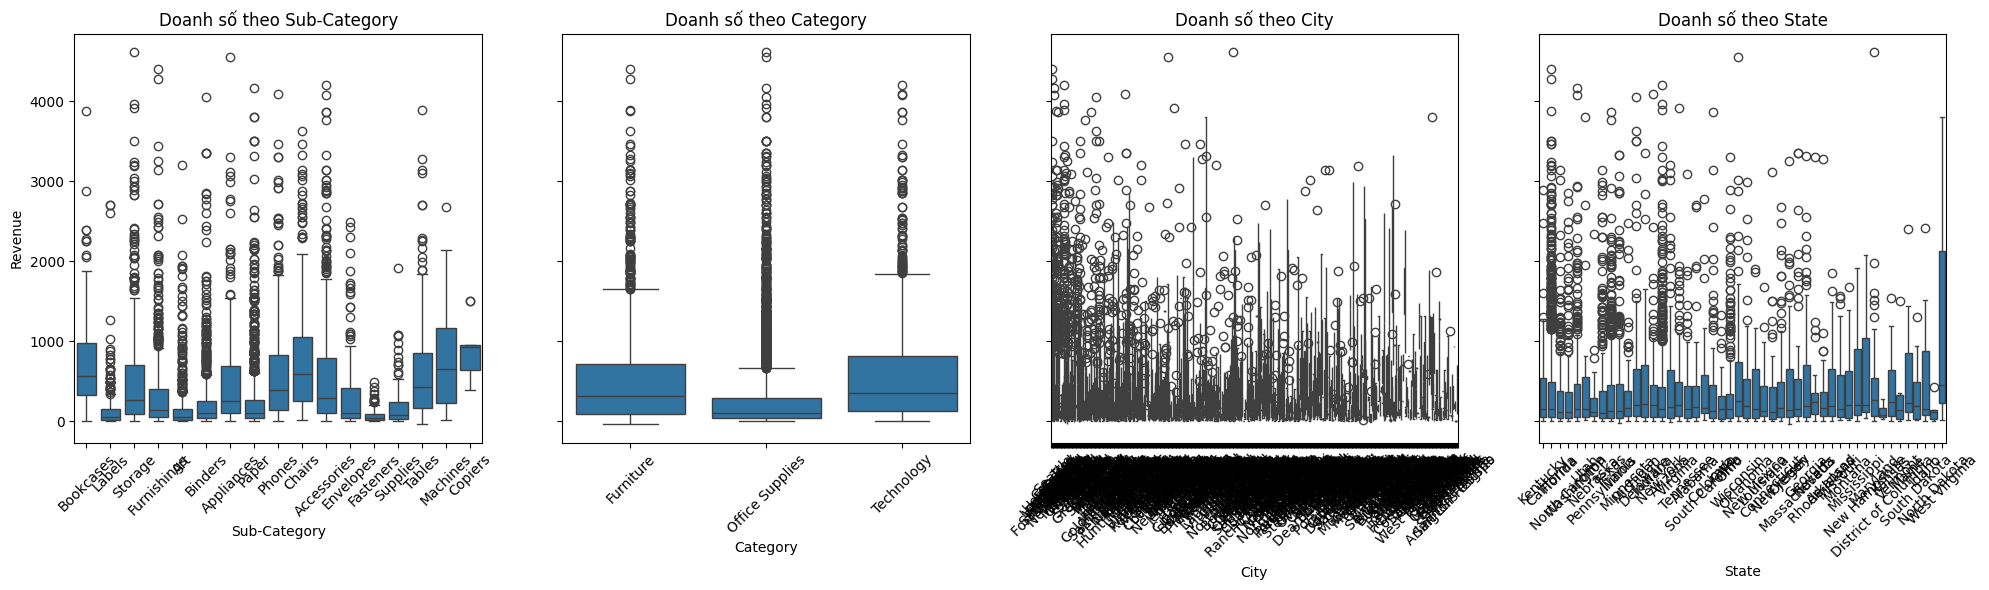

In [13]:

# --- 6. Trực quan hóa ANOVA bằng Boxplot (cho một số biến nổi bật) ---
# Chọn các biến định tính có p-value thấp nhất để trực quan hóa
top_anova_features = anova_df[anova_df['P-value'] < 0.05].index.tolist()[:4] # Chọn 4 biến có ý nghĩa nhất

if top_anova_features:
    print(f"\nTrực quan hóa ANOVA cho các biến: {top_anova_features}")
    num_plots = len(top_anova_features)
    fig, axes = plt.subplots(1, num_plots, figsize=(5 * num_plots, 6), sharey=True)
    if num_plots == 1: # Điều chỉnh nếu chỉ có 1 biểu đồ
        axes = [axes]

    for i, feature in enumerate(top_anova_features):
        sns.boxplot(x=feature, y='Revenue', data=df, ax=axes[i])
        axes[i].set_title(f'Doanh số theo {feature}')
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel('Revenue')
        axes[i].tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("\nKhông có biến định tính nào có P-value < 0.05 để trực quan hóa bằng Boxplot.")



In [ ]:

# --- 7. Lựa chọn các thuộc tính đầu vào cho mô hình dự đoán ---
# Tiêu chí lựa chọn:
# 1. Từ tương quan Pearson: Chọn các biến có Tương quan tuyệt đối (Absolute Correlation) cao (ví dụ: > 0.3 hoặc 0.5 tùy vào dữ liệu của bạn)
# 2. Từ ANOVA: Chọn các biến có P-value thấp (ví dụ: < 0.05), cho thấy có sự khác biệt đáng kể giữa các nhóm.

# Ví dụ lựa chọn:
selected_numerical_features = correlation_df[correlation_df['Absolute Correlation'] > 0.3]['Feature'].tolist()
selected_categorical_features_from_anova = anova_df[anova_df['P-value'] < 0.05].index.tolist()

# Đảm bảo Sales và Quantity luôn được chọn nếu chúng tồn tại, vì chúng có mối quan hệ trực tiếp
if 'Sales' in df.columns and 'Sales' not in selected_numerical_features:
    selected_numerical_features.append('Sales')
if 'Quantity' in df.columns and 'Quantity' not in selected_numerical_features:
    selected_numerical_features.append('Quantity')
if 'Profit' in df.columns and 'Profit' not in selected_numerical_features:
    selected_numerical_features.append('Profit')


final_features_for_model = list(set(selected_numerical_features + selected_categorical_features_from_anova))

print("\n--- Các thuộc tính được đề xuất làm input đầu vào cho mô hình dự đoán Revenue ---")
print(final_features_for_model)

print("\nBạn có thể sử dụng danh sách 'final_features_for_model' này cho bước xây dựng mô hình dự đoán tiếp theo.")

Dữ liệu đã được tải thành công!
Số lượng dòng ban đầu: 7888
Đã mã hóa cột 'Sub-Category'.
Đã mã hóa cột 'Category'.
Đã mã hóa cột 'City'.

Kích thước tập huấn luyện: 5048 dòng
Kích thước tập kiểm định (validation): 1262 dòng
Kích thước tập kiểm tra (test): 1578 dòng

--- Đang tinh chỉnh siêu tham số với RandomizedSearchCV cho LightGBM ---
Fitting 5 folds for each of 50 candidates, totalling 250 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000260 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 519
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 5
[LightGBM] [Info] Start training from score 374.914116
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

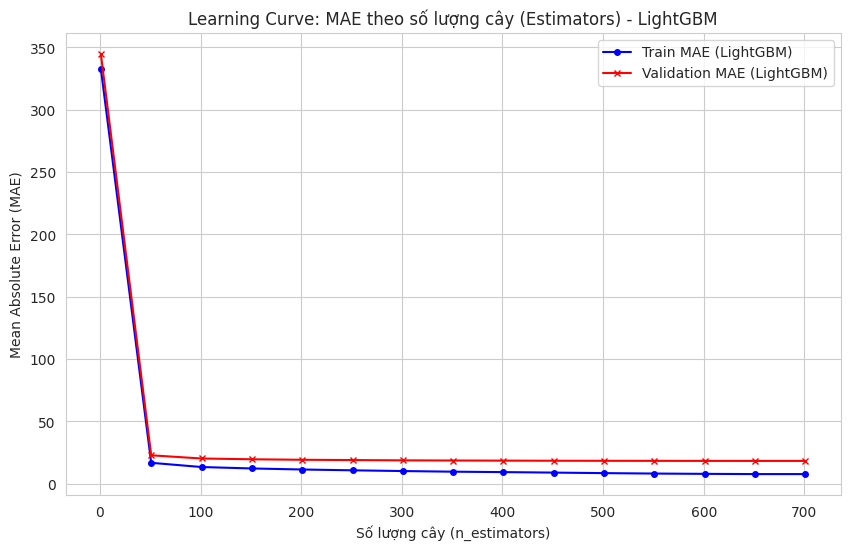


--- Đánh giá cuối cùng trên tập kiểm tra (Test Set) cho LightGBM ---
Test MAE: 19.08
Test RMSE: 43.02
Test R2: 0.9944

--- Ví dụ dự đoán với dữ liệu mới (sử dụng LightGBM) ---

Dữ liệu mới để dự đoán (sau khi mã hóa):
   Sub-Category  Category  City  Sales  Quantity
0            13         2   319    500         2
1             5         0   257    300         3

Doanh thu dự đoán cho dữ liệu mới:
Mẫu 1: Doanh thu dự đoán = 937.22
Mẫu 2: Doanh thu dự đoán = 900.14


In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import LightGBM
import lightgbm as lgb

# --- 1. Load Data ---
try:
    df = pd.read_csv('/content/analyzed_data.csv', encoding="windows-1252")
    print("Dữ liệu đã được tải thành công!")
    print(f"Số lượng dòng ban đầu: {len(df)}")
except FileNotFoundError:
    print("Lỗi: Không tìm thấy file 'analyzed_data.csv'. Vui lòng kiểm tra lại đường dẫn.")
    exit()

# --- 2. Chuẩn bị Dữ liệu ---
required_cols = ['Sub-Category', 'Category', 'City', 'Sales', 'Quantity', 'Revenue']
for col in required_cols:
    if col not in df.columns:
        print(f"Lỗi: Cột '{col}' không tồn tại trong DataFrame. Vui lòng kiểm tra lại tên cột.")
        exit()

for col in ['Sales', 'Quantity', 'Revenue']:
    if df[col].isnull().any():
        df[col] = df[col].fillna(df[col].mean())
        print(f"Đã xử lý giá trị thiếu cho cột '{col}' bằng giá trị trung bình.")

# Random Forest có thể xử lý tốt LabelEncoder. LightGBM cũng vậy.
# Đảm bảo các biến định tính được xử lý thành số nguyên.
# Đặc biệt quan trọng với LightGBM để nó có thể nhận diện các đặc trưng định tính nếu muốn.
# Tuy nhiên, với LabelEncoder, chúng ta đang coi chúng là số thứ tự.
# Để LightGBM xử lý chúng như biến định tính thực sự, chúng ta cần truyền categorical_feature vào LightGBM.
categorical_features_lgbm = ['Sub-Category', 'Category', 'City']

for col in categorical_features_lgbm:
    if df[col].isnull().any():
        df[col] = df[col].fillna('Unknown')
        print(f"Đã xử lý giá trị thiếu cho cột '{col}' bằng 'Unknown'.")

label_encoders = {}
for feature in categorical_features_lgbm:
    le = LabelEncoder()
    df[feature] = le.fit_transform(df[feature])
    label_encoders[feature] = le
    print(f"Đã mã hóa cột '{feature}'.")

X = df[['Sub-Category', 'Category', 'City', 'Sales', 'Quantity']]
y = df['Revenue']

# Chia dữ liệu thành tập huấn luyện, tập kiểm tra và tập kiểm định (validation)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

print(f"\nKích thước tập huấn luyện: {len(X_train)} dòng")
print(f"Kích thước tập kiểm định (validation): {len(X_val)} dòng")
print(f"Kích thước tập kiểm tra (test): {len(X_test)} dòng")

# --- 3. Tinh chỉnh siêu tham số (Hyperparameter Tuning) với RandomizedSearchCV cho LightGBM ---
print("\n--- Đang tinh chỉnh siêu tham số với RandomizedSearchCV cho LightGBM ---")

# Định nghĩa lưới các siêu tham số cho LightGBM
param_dist_lgbm = {
    'n_estimators': [100, 200, 300, 400, 500], # Số lượng cây
    'learning_rate': [0.01, 0.05, 0.1, 0.2], # Tốc độ học
    'num_leaves': [20, 31, 40, 50], # Số lá tối đa trong một cây
    'max_depth': [5, 7, 10, 12, -1], # Chiều sâu tối đa của cây (-1 nghĩa là không giới hạn)
    'min_child_samples': [20, 30, 40, 50], # Số lượng mẫu tối thiểu trong một nút lá
    'subsample': [0.7, 0.8, 0.9, 1.0], # Tỷ lệ lấy mẫu con của dữ liệu (row sampling)
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0], # Tỷ lệ lấy mẫu con của đặc trưng (column sampling)
    'reg_alpha': [0, 0.1, 0.5, 1.0], # L1 regularization
    'reg_lambda': [0, 0.1, 0.5, 1.0], # L2 regularization
}

mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

random_search_lgbm = RandomizedSearchCV(estimator=lgb.LGBMRegressor(random_state=42),
                                        param_distributions=param_dist_lgbm,
                                        n_iter=50, # Số lượng lặp (có thể tăng lên 100-200 nếu có thời gian)
                                        cv=5, # Số fold cross-validation
                                        scoring=mae_scorer,
                                        n_jobs=-1,
                                        verbose=1,
                                        random_state=42)

# Đối với LightGBM, truyền danh sách các cột định tính để nó xử lý tối ưu hơn
# (Lưu ý: LabelEncoder đã biến chúng thành số nguyên, LGBM có thể tận dụng thông tin này)
random_search_lgbm.fit(X_train, y_train,
                        eval_set=[(X_val, y_val)], # Sử dụng tập kiểm định để theo dõi hiệu suất trong quá trình huấn luyện
                        eval_metric='mae', # Sử dụng MAE làm metric theo dõi trên eval_set
                        callbacks=[lgb.early_stopping(100, verbose=False)]) # Dừng sớm nếu không cải thiện sau 100 vòng

print("\nTinh chỉnh siêu tham số LightGBM hoàn tất!")
print(f"Các siêu tham số tốt nhất: {random_search_lgbm.best_params_}")
print(f"MAE tốt nhất trên tập huấn luyện (cross-validation): {-random_search_lgbm.best_score_:.2f}")

model_lgbm = random_search_lgbm.best_estimator_

# --- 4. Đánh giá Mô hình và Chuẩn bị dữ liệu cho biểu đồ Learning Curve ---

y_train_pred_lgbm = model_lgbm.predict(X_train)
train_mae_lgbm = mean_absolute_error(y_train, y_train_pred_lgbm)
train_rmse_lgbm = np.sqrt(mean_squared_error(y_train, y_train_pred_lgbm))
train_r2_lgbm = r2_score(y_train, y_train_pred_lgbm)

y_val_pred_lgbm = model_lgbm.predict(X_val)
val_mae_lgbm = mean_absolute_error(y_val, y_val_pred_lgbm)
val_rmse_lgbm = np.sqrt(mean_squared_error(y_val, y_val_pred_lgbm))
val_r2_lgbm = r2_score(y_val, y_val_pred_lgbm)

print(f"\n--- Đánh giá trên tập huấn luyện (LightGBM đã tinh chỉnh) ---")
print(f"Train MAE: {train_mae_lgbm:.2f}")
print(f"Train RMSE: {train_rmse_lgbm:.2f}")
print(f"Train R2: {train_r2_lgbm:.4f}")

print(f"\n--- Đánh giá trên tập kiểm định (Validation) (LightGBM đã tinh chỉnh) ---")
print(f"Validation MAE: {val_mae_lgbm:.2f}")
print(f"Validation RMSE: {val_rmse_lgbm:.2f}")
print(f"Validation R2: {val_r2_lgbm:.4f}")

# Đối với LightGBM, việc lấy learning curve dễ hơn vì nó có eval_results_
# Tuy nhiên, eval_results_ là từ RandomizedSearchCV, nó theo dõi trên các fold cross-validation.
# Để vẽ learning curve giống như trước, chúng ta cần huấn luyện lại từng bước với số lượng cây.
train_maes_lgbm = []
val_maes_lgbm = []

best_n_estimators_lgbm = model_lgbm.n_estimators # Số lượng cây tốt nhất từ RandomizedSearchCV
# Tăng n_estimators lên một chút để thấy xu hướng sau điểm tối ưu
estimators_range_lgbm = np.arange(1, best_n_estimators_lgbm + max(50, int(best_n_estimators_lgbm * 0.5)), max(10, int(best_n_estimators_lgbm / 10)))
if len(estimators_range_lgbm) < 5 or estimators_range_lgbm[-1] < 100:
    estimators_range_lgbm = np.arange(1, max(best_n_estimators_lgbm + 100, 201), 20)

print("\nĐang tính toán hiệu suất với số lượng cây tăng dần để vẽ biểu đồ learning curve cho LightGBM...")
for n in estimators_range_lgbm:
    temp_lgbm_model = lgb.LGBMRegressor(n_estimators=int(n),
                                        learning_rate=model_lgbm.learning_rate,
                                        num_leaves=model_lgbm.num_leaves,
                                        max_depth=model_lgbm.max_depth,
                                        min_child_samples=model_lgbm.min_child_samples,
                                        subsample=model_lgbm.subsample,
                                        colsample_bytree=model_lgbm.colsample_bytree,
                                        reg_alpha=model_lgbm.reg_alpha,
                                        reg_lambda=model_lgbm.reg_lambda,
                                        random_state=42,
                                        n_jobs=-1)

    temp_lgbm_model.fit(X_train, y_train,
                        eval_set=[(X_val, y_val)],
                        eval_metric='mae',
                        callbacks=[lgb.early_stopping(50, verbose=False)]) # Dừng sớm nhẹ để tiết kiệm thời gian vẽ curve

    y_train_temp_pred_lgbm = temp_lgbm_model.predict(X_train)
    train_maes_lgbm.append(mean_absolute_error(y_train, y_train_temp_pred_lgbm))

    y_val_temp_pred_lgbm = temp_lgbm_model.predict(X_val)
    val_maes_lgbm.append(mean_absolute_error(y_val, y_val_temp_pred_lgbm))

# --- 5. Vẽ Biểu đồ Độ mất mát (Loss) cho LightGBM ---

plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
plt.plot(list(estimators_range_lgbm), train_maes_lgbm, label='Train MAE (LightGBM)', color='blue', marker='o', markersize=4)
plt.plot(list(estimators_range_lgbm), val_maes_lgbm, label='Validation MAE (LightGBM)', color='red', marker='x', markersize=4)
plt.title('Learning Curve: MAE theo số lượng cây (Estimators) - LightGBM')
plt.xlabel('Số lượng cây (n_estimators)')
plt.ylabel('Mean Absolute Error (MAE)')
plt.legend()
plt.grid(True)
plt.show()

print("\n--- Đánh giá cuối cùng trên tập kiểm tra (Test Set) cho LightGBM ---")
y_test_pred_lgbm = model_lgbm.predict(X_test)
test_mae_lgbm = mean_absolute_error(y_test, y_test_pred_lgbm)
test_mse_lgbm = mean_squared_error(y_test, y_test_pred_lgbm)
test_rmse_lgbm = np.sqrt(test_mse_lgbm)
test_r2_lgbm = r2_score(y_test, y_test_pred_lgbm)

print(f"Test MAE: {test_mae_lgbm:.2f}")
print(f"Test RMSE: {test_rmse_lgbm:.2f}")
print(f"Test R2: {test_r2_lgbm:.4f}")

# --- 6. Dự đoán với Dữ liệu mới (Ví dụ) ---
print("\n--- Ví dụ dự đoán với dữ liệu mới (sử dụng LightGBM) ---")
new_data = pd.DataFrame({
    'Sub-Category': ['Phones', 'Chairs'],
    'Category': ['Technology', 'Furniture'],
    'City': ['New York City', 'Los Angeles'],
    'Sales': [500, 300],
    'Quantity': [2, 3]
})

for feature in categorical_features_lgbm: # Sử dụng danh sách các biến định tính
    new_data[feature] = new_data[feature].apply(
        lambda x: label_encoders[feature].transform([x])[0] if x in label_encoders[feature].classes_ else -1
    )

print("\nDữ liệu mới để dự đoán (sau khi mã hóa):")
print(new_data)

predicted_revenue_lgbm = model_lgbm.predict(new_data)
print("\nDoanh thu dự đoán cho dữ liệu mới:")
for i, pred in enumerate(predicted_revenue_lgbm):
    print(f"Mẫu {i+1}: Doanh thu dự đoán = {pred:.2f}")

In [6]:
import joblib
import os # Để quản lý đường dẫn file



In [7]:
model_filename = 'lgbm_revenue_prediction_model.joblib'
label_encoders_filename = 'label_encoders.joblib'
output_dir = 'saved_models'
os.makedirs(output_dir, exist_ok=True) # Tạo thư mục nếu chưa tồn tại
model_path = os.path.join(output_dir, model_filename)
label_encoders_path = os.path.join(output_dir, label_encoders_filename)

In [8]:
try:
    joblib.dump(model_lgbm, model_path)
    print(f"\nMô hình đã được lưu thành công tại: {model_path}")

    joblib.dump(label_encoders, label_encoders_path) # Rất quan trọng: Lưu cả các LabelEncoder!
    print(f"Các LabelEncoder đã được lưu thành công tại: {label_encoders_path}")

except Exception as e:
    print(f"Lỗi khi lưu mô hình hoặc LabelEncoders: {e}")


Mô hình đã được lưu thành công tại: saved_models/lgbm_revenue_prediction_model.joblib
Các LabelEncoder đã được lưu thành công tại: saved_models/label_encoders.joblib
